In [ ]:
# import numpy as np
# import pickle
# import matplotlib.pyplot as plt
# from pathlib import Path
# from tqdm import trange

# import flygym.common
# import flygym.mujoco
# import flygym.mujoco.preprogrammed

In [1]:
from flygym.mujoco import Parameters, NeuroMechFly
from flygym.mujoco.arena import FlatTerrain
from flygym.mujoco.arena.tethered import Tethered
from flygym.mujoco.examples.common import PreprogrammedSteps
from flygym.mujoco.examples.common import PreprogrammedSteps
import numpy as np
from IPython.display import Video
import matplotlib.pyplot as plt

In [2]:
class WindArena(Tethered):
    def __init__(
        self,
        wind_vector=[-6.0, 0.0, 0.0],
        medium_density=0.01,
        medium_viscosity=0.01,
        **kwargs
    ):
        super().__init__(**kwargs)
        self._add_wind(wind_vector, medium_density, medium_viscosity)

    def _add_wind(self, wind_vector, medium_density, medium_viscosity):
        # Here I directly change the fields of the xml option element
        self.root_element.option.__setattr__("density", medium_density)
        self.root_element.option.__setattr__("viscosity", medium_viscosity)
        self.root_element.option.__setattr__("wind", wind_vector)


wind_arena = WindArena()

In [244]:
#wind_nmf = NeuroMechFly(Parameters(render_camera="Animat/camera_front_zoomin", render_playspeed=0.02), arena=WindArena())

# run_total_time = 0.5
# target_num_steps = int(run_total_time / wind_nmf.timestep)

# preprogrammed_steps = PreprogrammedSteps()
# leg_action = []
# for leg in preprogrammed_steps.legs:
#     # fly is standing
#     leg_action.extend(preprogrammed_steps.get_joint_angles(leg, 0.0))


# # run a simulation with wind
# for i in range(target_num_steps):
#     obs, reward, terminated, truncated, info = wind_nmf.step({"joints": leg_action})
#     wind_nmf.render()

In [3]:
from typing import Any, Dict, Tuple


class AristaNMF(NeuroMechFly):
    def _set_joints_stiffness_and_damping(self):
        for joint in self.model.find_all("joint"):
            if joint.name in self.actuated_joints:
                joint.stiffness = self.sim_params.joint_stiffness
                joint.damping = self.sim_params.joint_damping
            elif "Arista" in joint.name:
                joint.stiffness = 0.002
                joint.damping = 1e-5
            elif "Head" in joint.name:
                joint.stiffness = 1000.0
                joint.damping = 1000.0
            else:
                joint.stiffness = self.sim_params.non_actuated_joint_stiffness
                joint.damping = self.sim_params.non_actuated_joint_damping
            

    def _add_joint_sensors(self):
        self._arista_sensors = []
        self._debug_end_effectors = []

        for side in "LR":
            arista_sensor_joint = self.model.sensor.add(
                "jointpos", name=f"jointpos_{side}Arista", joint=f"joint_{side}Arista"
            )
            arista_sensor_torque = self.model.sensor.add(
                "jointactuatorfrc", name=f"jointactuatorfrc_{side}Arista", joint=f"joint_{side}Arista"
            )
            self._arista_sensors.append(arista_sensor_torque)
            self._arista_sensors.append(arista_sensor_joint)
            
            

        return super()._add_joint_sensors()
    
    # def _add_force_sensors(self):
    #     self._arista_sensors = []

    #     for side in "LR":
    #         arista_sensor = self.model.sensor.add(
    #             "jointactuatorfrc",
    #             name=f"force_{side}Arista",
    #             actuator=f"actuator_torque_{side}Arista",
    #         )

    #         self._arista_sensors.append(arista_sensor)

    #    return super()._add_force_sensors()


    def get_observation(self):
        obs = super().get_observation()
        arista_obs = self.physics.bind(self._arista_sensors).sensordata
        obs["arista_joint_pos"] = arista_obs.copy()
        
        return obs


arista_nmf = AristaNMF(Parameters())
arista_nmf._arista_sensors

[MJCF Element: <jointactuatorfrc name="jointactuatorfrc_LArista" joint="joint_LArista"/>,
 MJCF Element: <jointpos name="jointpos_LArista" joint="joint_LArista"/>,
 MJCF Element: <jointactuatorfrc name="jointactuatorfrc_RArista" joint="joint_RArista"/>,
 MJCF Element: <jointpos name="jointpos_RArista" joint="joint_RArista"/>]

In [4]:
preprogrammed_steps = PreprogrammedSteps()
leg_action = []
for leg in preprogrammed_steps.legs:
    # fly is standing
    leg_action.extend(preprogrammed_steps.get_joint_angles(leg, 0.0))

In [6]:
obs_list = []

arista_nmf = AristaNMF(
    Parameters(render_camera="Animat/camera_front_zoomin", render_playspeed=0.1), arena = WindArena(), init_pose="stretch"
)
run_time = 0.4
target_num_steps = int(run_time / arista_nmf.timestep)
action = {"joints": leg_action}

# run a simulation and bend the abdomen
obs, info = arista_nmf.reset()
end_effector_L = []
end_effector_R = []

for i in range(target_num_steps):
    # # here, we simply use the recorded joint angles as the target joint angles
    obs, reward, terminated, truncated, info = arista_nmf.step(action)
    obs_list.append(obs)    
    end_effector_L.append(arista_nmf.physics.named.data.qpos[f"Animat/joint_LArista"])
    end_effector_R.append(arista_nmf.physics.named.data.qpos[f"Animat/joint_RArista"])

   
    arista_nmf.render()

arista_nmf.save_video("arista.mp4", 0)

In [7]:
obs_list[0].keys()

dict_keys(['joints', 'fly', 'contact_forces', 'end_effectors', 'fly_orientation', 'arista_joint_pos'])

In [8]:
jnt = arista_nmf.physics.model.jnt("Animat/joint_LArista")
print(jnt.stiffness, jnt.axis, arista_nmf.physics.model.id2name(jnt.bodyid, "body"))

jnt2 = arista_nmf.physics.model.jnt("Animat/joint_RArista")
print(jnt2.stiffness, jnt2.axis, arista_nmf.physics.model.id2name(jnt2.bodyid, "body"))

[0.002] [0. 1. 0.] Animat/LArista
[0.002] [0. 1. 0.] Animat/RArista


In [9]:
qpos = arista_nmf.physics.named.data.qpos["Animat/joint_LArista"]
print(qpos)

qpos = arista_nmf.physics.named.data.qpos["Animat/joint_RArista"]
print(qpos)

[-0.24783211]
[-0.05195953]


In [10]:
Video("./arista.mp4")

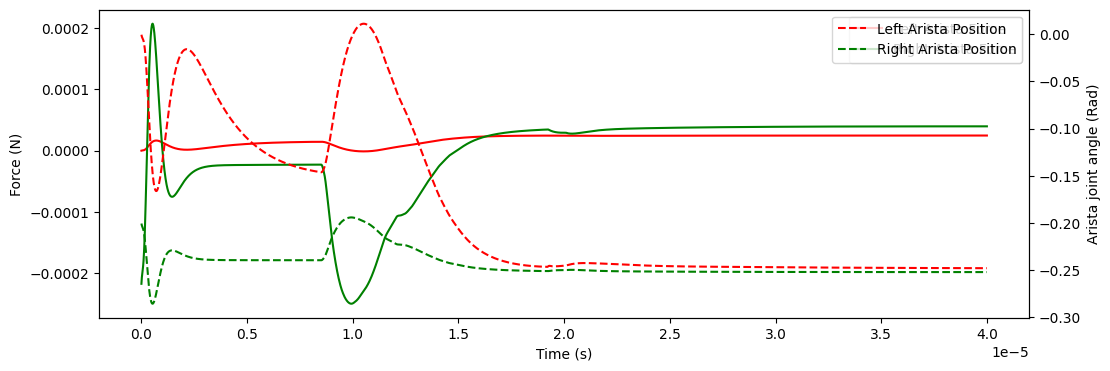

In [11]:
arista_joint = np.array([obs["arista_joint_pos"] for obs in obs_list])
time = np.linspace(0, run_time, target_num_steps) * arista_nmf.timestep

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(12, 4))

# Plotting the first and third curves on the left y-axis
ax1.plot(time, arista_joint[:, 0], 'r',label="Left Arista Force")
ax1.plot(time, arista_joint[:, 2]-0.00022,'g', label="Right Arista Force")
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Force (N)')
ax1.legend(loc='best')

# Create a second y-axis for the second and fourth curves
ax2 = ax1.twinx()
ax2.plot(time, arista_joint[:, 1], 'r--', label="Left Arista Position")
ax2.plot(time, arista_joint[:, 3]-0.2, 'g--', label="Right Arista Position")
ax2.set_ylabel('Arista joint angle (Rad)')
ax2.legend(loc='best')

plt.show()

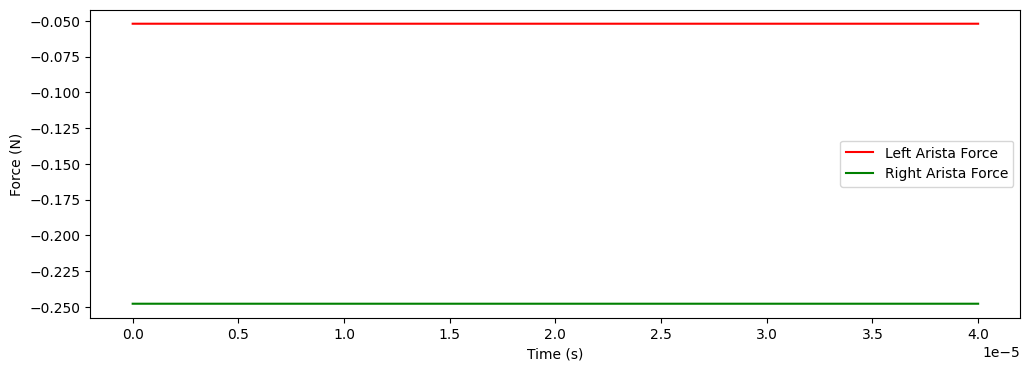

In [12]:
#arista_joint = np.array([obs["arista_end_eff"] for obs in obs_list])
time = np.linspace(0, run_time, target_num_steps) * arista_nmf.timestep

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(12, 4))

# Plotting the first and third curves on the left y-axis
ax1.plot(time, end_effector_R, 'r',label="Left Arista Force")
ax1.plot(time, end_effector_L,'g', label="Right Arista Force")
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Force (N)')
ax1.legend(loc='best')

In [ ]:
mm/s^2 kg

SyntaxError: invalid syntax (1377808331.py, line 1)